In [2]:
import numpy as np
import pandas as pd
import multiprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skopt import gp_minimize
from skopt.space import Real, Categorical, Space
from skopt.utils import use_named_args
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.neighbors import NearestNeighbors

import json
class NumpyEncoder(json.JSONEncoder):
    """自定义JSON编码器，用于处理numpy数据类型"""
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NumpyEncoder, self).default(obj)

In [15]:
def estimate_ess(Y, W, X, alpha, support_indices):
        weights = np.zeros(X.shape[0])
        weights[support_indices] = np.abs(alpha)
        alpha = weights / np.sum(weights)
        
        treated_ess = (np.sum(alpha[W == 1]))**2 / np.sum(alpha[W == 1]**2)
        control_ess = (np.sum(alpha[W == -1]))**2 / np.sum(alpha[W == -1]**2)

        return treated_ess + control_ess
    
def estimate_diff(Y, W, X, alpha, support_indices):

    # 计算权重
    weights = np.zeros(X.shape[0])
    weights[support_indices] = np.abs(alpha)
    alpha = weights / np.sum(weights)
    
    treated_mean = np.mean(Y[W == 1])
    control_mean = np.mean(Y[W == -1])
    
    treated_std = np.std(Y[W == 1], ddof=1)
    control_std = np.std(Y[W == -1], ddof=1)

    normed_diff = np.abs(treated_mean - control_mean) / np.sqrt((treated_std**2 + control_std**2) / 2)

    return normed_diff

def estimate_ate(Y, W, X, alpha, support_indices):
    
    # 计算权重
    weights = np.zeros(X.shape[0])
    weights[support_indices] = np.abs(alpha)
    alpha = weights / np.sum(weights)
    
    treated_mean = np.sum(Y[W == 1] * alpha[W == 1]) / np.sum(alpha[W == 1])
    control_mean = np.sum(Y[W == -1] * alpha[W == -1]) / np.sum(alpha[W == -1])
    return treated_mean - control_mean



def compute_wnayman(Y_obs, W, X, alpha, support_indices):
    
    # 计算权重
    weights = np.zeros(X.shape[0])
    weights[support_indices] = np.abs(alpha)
    lambda_i = weights / np.sum(weights)
    
    # 计算mu_c(x)和mu_t(x)，这里需要根据具体数据进行定义
    mu_c = np.mean(Y_obs[W == -1])
    mu_t = np.mean(Y_obs[W == 1])

    # 计算sigma_c^2(x)和sigma_t^2(x)，这里需要根据具体数据进行定义
    sigma_c_squared = np.var(Y_obs[W == -1])
    sigma_t_squared = np.var(Y_obs[W == 1])

    # 计算mu_i和sigma_i^2
    mu_i = np.where(W == -1, mu_c, mu_t)
    sigma_i_squared = np.where(W == -1, sigma_c_squared, sigma_t_squared)

    N_t = np.sum(W == 1)
    N_c = np.sum(W == -1)

    # 计算条件抽样方差
    conditional_variance = np.sum(lambda_i[W == 1]**2 * sigma_i_squared[W == 1]) + np.sum(lambda_i[W == -1]**2 * sigma_i_squared[W == -1])
    
    stderr = np.sqrt(conditional_variance)


    print("条件抽样方差:", conditional_variance)
    return stderr

class ConvergenceStopper:
    def __init__(self, patience=10, tol=1e-6):
        self.patience = patience
        self.tol = tol
        self.best_value = np.inf
        self.no_improvement = 0
    
    def __call__(self, result):
        if len(result.x_iters) < 10:  # 至少10个点才开始检查
            return False
        
        current_min = np.min(result.func_vals)
        
        if self.best_value - current_min > self.tol:
            self.best_value = current_min
            self.no_improvement = 0
        else:
            self.no_improvement += 1
            
        return self.no_improvement >= self.patience

class BOStopper:
    def __init__(self, conv_patience=10, conv_tol=1e-8,
                 ci_width=0.2, ci_patience=10, max_iter=100):
        self.conv_stopper = ConvergenceStopper(conv_patience, conv_tol)
        # self.ci_stopper = ConfidenceIntervalStopper(ci_width, ci_patience)
        self.max_iter = max_iter
    
    def __call__(self, result):
        # 最大迭代次数检查
        if len(result.x_iters) >= self.max_iter:
            return True
            
        # 收敛检查
        if self.conv_stopper(result):
            return True
        
        # 置信区间检查
        # if self.ci_stopper(result):
        #     return True
            
        return False
    

def bayesian_opt(Y, X, W, kernel, c_upper): 
    # Define the hyperparameter space
    STD_C = Real(low=1e-3, high=c_upper, prior='log-uniform', name='C')
    dim_class_weight_1 = Real(low=0.1, high=2.0, prior='uniform', name='class_weight_1')
    dim_class_weight_neg1 = Real(low=0.1, high=2.0, prior='uniform', name='class_weight_neg1')


    dimensions = [STD_C, dim_class_weight_1, dim_class_weight_neg1]

    # Define the target score function
    @use_named_args(dimensions=dimensions)
    def objective_1(**params):
        class_weight = {1: params['class_weight_1'], -1: params['class_weight_neg1']}
        clf = SVC(C=params['C'], kernel=kernel, class_weight=class_weight)
        # return score  # We negate because we want to maximize accuracy
    
        clf.fit(X_train, W_train)
        score = clf.score(X_test, W_test)
        # ess = estimate_ess(Y, W, X, alpha, support_indices)
        return -score

    @use_named_args(dimensions=dimensions)
    def objective_2(**params):
        class_weight = {1: params['class_weight_1'], -1: params['class_weight_neg1']}
        clf = SVC(C=params['C'], kernel=kernel, class_weight=class_weight)
        # return score  # We negate because we want to maximize accuracy
    
        clf.fit(X_test, W_test)
        score = clf.score(X_train, W_train)
        # ess = estimate_ess(Y, W, X, alpha, support_indices)
        return -score

    def crossfitting(result, Y, X, W):
        best_params = result.x
        best_score = result.fun  # Negate to get the actual score

        C = best_params[0]
        class_weight = {1: best_params[1], -1: best_params[2]}

        best_model = SVC(C=C, kernel=kernel)
        best_model.fit(X, W)
        support_indices = best_model.support_
        alpha = np.abs(best_model.dual_coef_[0])
        ATE = estimate_ate(Y, W, X, alpha, support_indices)
        DIM = estimate_diff(Y, W, X, alpha, support_indices)
        ESS = estimate_ess(Y, W, X, alpha, support_indices)
        STD = compute_wnayman(Y, W, X, alpha, support_indices)
        
        print("Best Hyperparameters:", best_params)
        print("Best Cross-Validation Score:", best_score)
        print("ATE:", ATE)
        print("STD:", STD)

        class_weight = best_params[1]/best_params[2]

        return(ATE, DIM, ESS, C, class_weight, STD)
    
    # Initialize the Bayesian Optimization
    n_initial_points = 5
    # n_calls = 50

    # 定义综合停止器
    stopper_1 = BOStopper(
        conv_patience=10,
        conv_tol=1e-6,
        # ci_width=0.2,
        # ci_patience=10,
        max_iter=100
    )
    
    stopper_2 = BOStopper(
        conv_patience=10,
        conv_tol=1e-6,
        # ci_width=0.2,
        # ci_patience=10,
        max_iter=100
    )

    Y_train, Y_test, X_train, X_test, W_train, W_test = train_test_split(Y, X, W, test_size=0.5, random_state=42)

    result_1 = gp_minimize(objective_1, dimensions, n_initial_points=n_initial_points, callback=[stopper_1], random_state=42, verbose=True)
    result_1 = crossfitting(result_1, Y_test, X_test, W_test)

    result_2 = gp_minimize(objective_2, dimensions, n_initial_points=n_initial_points, callback=[stopper_2], random_state=42, verbose=True)
    result_2 = crossfitting(result_2, Y_train, X_train, W_train)

    ATE = (result_1[0] + result_2[0])/2
    DIM = (result_1[1] + result_2[1])/2
    ESS = result_1[2] + result_2[2]
    C = (result_1[3] + result_2[3])/2
    class_weight = (result_1[4] + result_2[4])/2
    STD = (result_1[5] + result_2[5])/2

    return(ATE, DIM, ESS, C, class_weight, STD)

In [ ]:
# Define the dataset and hyperparameter space
num_datasets = 100
simulation_results_A = {n: [] for n in range(num_datasets)}


kernels = ['linear']
# pi_range = np.linspace(0.0, 1.0, 11)

# pi_range = [0.0]
# results = {pi: [] for pi in pi_range}


c_uppers = [1e-2, 1e-1, 1e+0]

results = {c_upper: [] for c_upper in c_uppers}

with open('../results/rbf/simu_B2_w_100_2000_f.json', 'r') as f:
    data_str = f.read()


results = json.loads(data_str)

# results['1.0'] = []
# results['10.0'] = []
# results['100.0'] = []

for n in range(num_datasets):
    # simulate_data = pd.read_csv('../data_A_2000/data_scenario_G_n_500_dataset_{}.csv'.format(n))
    simulate_data = pd.read_csv('../data_B3_2000/dataset_{}.csv'.format(n))

    X = simulate_data.drop(columns=['T', 'Y'])
    T = simulate_data['T']
    Y = simulate_data['Y']

    W = 2 * T - 1

    for kernel in kernels:
        for c_upper in c_uppers:
            result = bayesian_opt(Y, X, W, kernel, c_upper) 

            results[c_upper].append(result)


        data = results

        data_str = json.dumps(data, cls=NumpyEncoder, indent=4)

        with open(f'../results/{kernel}/simu_B3_w_100_2000_f.json', 'w') as f:
            f.write(data_str)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3504
Function value obtained: -0.8310
Current minimum: -0.8310
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0788
Function value obtained: -0.8310
Current minimum: -0.8310
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2693
Function value obtained: -0.8310
Current minimum: -0.8310
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3071
Function value obtained: -0.8310
Current minimum: -0.8310
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.5358
Function value obtained: -0.8310
Current minimum: -0.8310
Iteration No: 6 started. 

KeyboardInterrupt: 

In [ ]:
import json
with open('../results/rbf/simu_B_2.0_w_20.json', 'r') as f:
    data_str = f.read()

results = json.loads(data_str)
print(results)

c_upper = []
kernel_ate_estimates = []
for c_uppers, models in results.items():
    for model in models:
        c_upper.append(float(c_uppers))
        kernel_ate_estimates.append(float(model[0]))

data = pd.DataFrame({'c_upper': c_upper, 'ATE': kernel_ate_estimates})

# 分组
grouped_data = data.groupby('c_upper')['ATE'].apply(list).tolist()

# 计算每个分组的平均值和方差
grouped_stats = []
for group in grouped_data:
    mean = np.mean(group)
    variance = np.var(group, ddof=1)  # 使用样本方差
    grouped_stats.append({'mean': mean, 'variance': variance})

# 打印结果
for i, stats in enumerate(grouped_stats):
    print(f"c_upper: 1e+{i+3}, Mean: {stats['mean']}, Variance: {stats['variance']}")

NameError: name 'results' is not defined

In [12]:
##PLOT ATE
def plot_ate(results):

    kernel = 'rbf'

    fig, axes = plt.subplots(1, 3,figsize=(12, 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    i= 0

    # 过滤出当前kernel的所有模型
    i = i  
    c_upper = []
    kernel_ate_estimates = []
    for c_uppers, models in results.items():
        for model in models:
            c_upper.append(float(c_uppers))
            kernel_ate_estimates.append(float(model[0]))

    data = pd.DataFrame({'c_upper': c_upper, 'ATE': kernel_ate_estimates})
    grouped_data = data.groupby('c_upper')['ATE'].apply(list).tolist()
    #print(sorted(set(pi)))
    print(grouped_data)

    # x_sticks = pi
    x_values = [f"$10^{{{int(np.log10(c))} }}$" for c in sorted(set(c_upper))]
    print(x_values)
    # 绘制箱型图
    axes[i].boxplot(grouped_data)
    # axes[i].axhline(y=-0.4, color='r', linestyle='--', label='True ATE (A)')
    axes[i].axhline(y=10, color='r', linestyle='--', label='True ATE (B)')
    #axes[i].set_xscale('log')
    axes[i].set_title(f'{kernel}')
    #axes[i].set_xticks(x_sticks)  # 保持刻度位置不变
    axes[i].set_xticklabels(x_values)
    axes[i].set_xlabel('c_upper')
    axes[i].set_ylabel('ATE')
    axes[i].legend()

    i += 1

    i = i  
    c_upper = []
    ESS = []
    for c_uppers, models in results.items():
        for model in models:
            c_upper.append(float(c_uppers))
            ESS.append(float(model[2]))

    data = pd.DataFrame({'c_upper': c_upper, 'ESS': ESS})
    grouped_data = data.groupby('c_upper')['ESS'].apply(list).tolist()
    #print(sorted(set(pi)))
    print(grouped_data)

    # x_sticks = pi
    x_values = [f"$10^{{{int(np.log10(c))} }}$" for c in sorted(set(c_upper))]
    # 绘制箱型图
    axes[i].boxplot(grouped_data)
    axes[i].axhline(y=1000, color='r', linestyle='--', label='SS')
    #axes[i].set_xscale('log')
    axes[i].set_title(f'{kernel}')
    #axes[i].set_xticks(x_sticks)  # 保持刻度位置不变
    axes[i].set_xticklabels(x_values)
    axes[i].set_xlabel('c_upper')
    axes[i].set_ylabel('ESS')
    axes[i].legend()

    i += 1

    # i = i  
    # c_upper = []
    # DIM = []
    # for c_uppers, models in results.items():
    #     for model in models:
    #         c_upper.append(float(c_uppers))
    #         DIM.append(float(model[1]))
    

    # data = pd.DataFrame({'c_upper': c_upper, 'DIM': DIM})
    # grouped_data = data.groupby('c_upper')['DIM'].apply(list).tolist()
    # print(grouped_data)

    # x_values = [f"$10^{{{int(np.log10(c))} }}$" for c in sorted(set(c_upper))]
    # # 绘制箱型图
    # axes[i].boxplot(grouped_data)
    # axes[i].set_title(f'{kernel}')
    # axes[i].set_xticklabels(x_values)
    # axes[i].set_xlabel('c_upper')
    # axes[i].set_ylabel('DIM')
    # axes[i].legend()

    i = i
    c_upper = []
    STD = []
    for c_uppers, models in results.items():
        for model in models:
            c_upper.append(float(c_uppers))
            STD.append(float(model[5]))
    
    data = pd.DataFrame({'c_upper': c_upper, 'STD': STD})
    grouped_data = data.groupby('c_upper')['STD'].apply(list).tolist()
    print(grouped_data)

    x_values = [f"$10^{{{int(np.log10(c))} }}$" for c in sorted(set(c_upper))]
    # 绘制箱型图
    axes[i].boxplot(grouped_data)
    axes[i].set_title(f'{kernel}')
    axes[i].set_xticklabels(x_values)
    axes[i].set_xlabel('c_upper')
    axes[i].set_ylabel('STD')
    axes[i].legend()


    plt.tight_layout()
    plt.show()

[[13.118873938066315, 12.08615047488189, 10.923756992012699, 10.538107113204433, 12.220051743737898, 14.266066411533231, 12.42327358765408, 13.020709160147362, 11.072044079524588, 14.897187180306545, 13.803536063969418, 13.526516832917281, 11.486496636695577, 13.700349965035102, 12.091826725390376, 12.615975892943908, 13.827903950883979, 14.488713970653691, 12.177913470299146, 12.864330955669487, 12.183725072543723, 7.61530722244342, 13.4796448626076, 10.637827080003987, 12.125816759007549, 10.57346673953495, 12.853470276617301, 11.844320428345156, 13.353923905568323, 11.701288949103699, 10.842616121643715, 15.773724241941807, 9.043375520916598, 14.799795933818416, 14.512492498689483, 12.992282671827226, 9.806113497361054, 10.685371023504288, 12.014069188129938, 9.381326396509508, 10.669610559040635, 10.87878179710816, 10.106263470486383, 10.233131399931352, 11.549820161714806, 11.661343628548877, 13.415774027153319, 10.944611199311566, 13.669051233002278, 14.386381322926255, 12.193776

C:\Users\rmaat\AppData\Local\Temp\ipykernel_2780\2332384574.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()


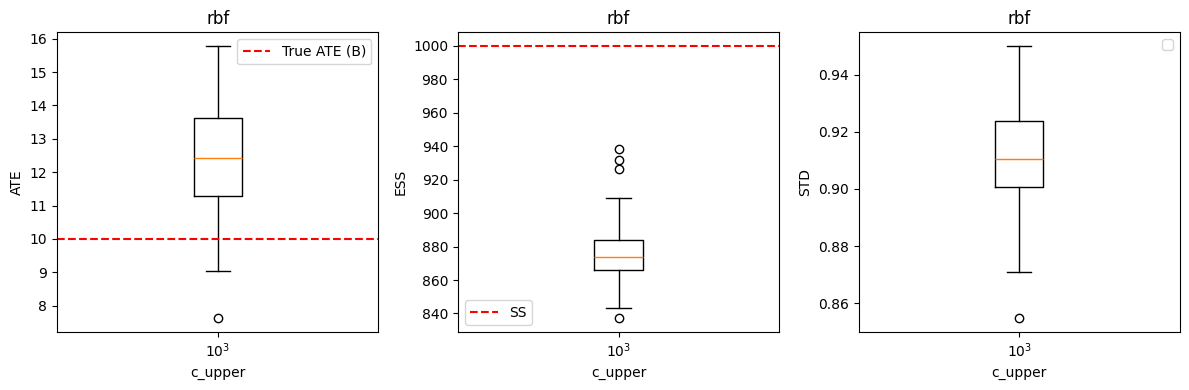

In [13]:
plot_ate(results)